# Check that the estimate of the linearization error scales correctly

We should have $|u^{\infty}-u^{\infty,b}|\propto \sqrt{\kappa^3/\Delta}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pointscat import *


plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['+Computer Modern'],
    'font.size': 25,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Experiment: we consider several values of $\kappa$ and $\Delta$. For each value of $\Delta$, we draw several configurations of two points $x_1,x_2$ satisfying $|x_1-x_2|=\Delta$

In [2]:
κ_tab = np.logspace(-1, 2, 8)
Δ_tab = np.logspace(-3, 3, 8)
num_draws = 5
num_measurements = 10  # number of indicent angles and observations directions

incident_angles = 2 * np.pi * np.random.random(num_measurements)
observation_directions = 2 * np.pi * np.random.random(num_measurements)

err_tab = []

for κ in κ_tab:
    err_tab_κ = []
    
    for Δ in Δ_tab:
        err_tab_Δ = []
        
        first_locations = 2 * np.random.random((num_draws, 2)) - 1
        angles = 2 * np.pi * np.random.random(num_draws)
        second_locations = first_locations + Δ * np.stack([np.cos(angles), np.sin(angles)], axis=1)
    
        for j in range(num_draws):
            locations = np.vstack([first_locations[j], second_locations[j]])
            assert np.isclose(np.linalg.norm(first_locations[j] - second_locations[j]), Δ)

            point_scat = PointScatteringProblem(locations, np.ones(2), κ)

            # far field computation (with and without Born approximation)
            far_field_born = point_scat.compute_far_field(incident_angles, observation_directions, born_approx=True)
            far_field = point_scat.compute_far_field(incident_angles, observation_directions)

            # computation of the error on the (discretized) far field
            err = np.linalg.norm(far_field - far_field_born) / np.sqrt(num_measurements) * (2*np.pi)
            err_tab_Δ.append(err)
        
        err_tab_κ.append(err_tab_Δ)
    
    err_tab.append(err_tab_κ)
    
err_tab = np.array(err_tab)

In [3]:
# computation of the theoretical upper bound on the error
X, Y = np.meshgrid(np.logspace(-1, 2, 100), np.logspace(-3, 3, 100))
th_err_tab = np.zeros((X.shape[0], X.shape[1]))

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        κ = X[i, j]
        Δ = Y[i, j]

        green_function_val = green_function(κ, np.array([0, 0]), Δ * np.array([1, 0]))
        aux = κ**2 * green_function_val
        
        # th_bound = 4*np.pi * np.abs(aux) / np.abs(1 - aux**2) * (np.abs(aux) * mean_amp + geom_mean_amp)
        err_th = 4*np.pi * np.abs(aux) / (1 - np.abs(aux))
        th_err_tab[i, j] = err_th

/tmp/ipykernel_58176/3927120595.py:45: RuntimeWarning: invalid value encountered in log10
  surf = ax_1.plot_surface(np.log10(X), np.log10(Y), np.log10(th_err_tab_plot),
/tmp/ipykernel_58176/3927120595.py:75: RuntimeWarning: invalid value encountered in log10
  surf = ax_2.plot_surface(np.log10(X), np.log10(Y), np.log10(th_err_tab_plot),


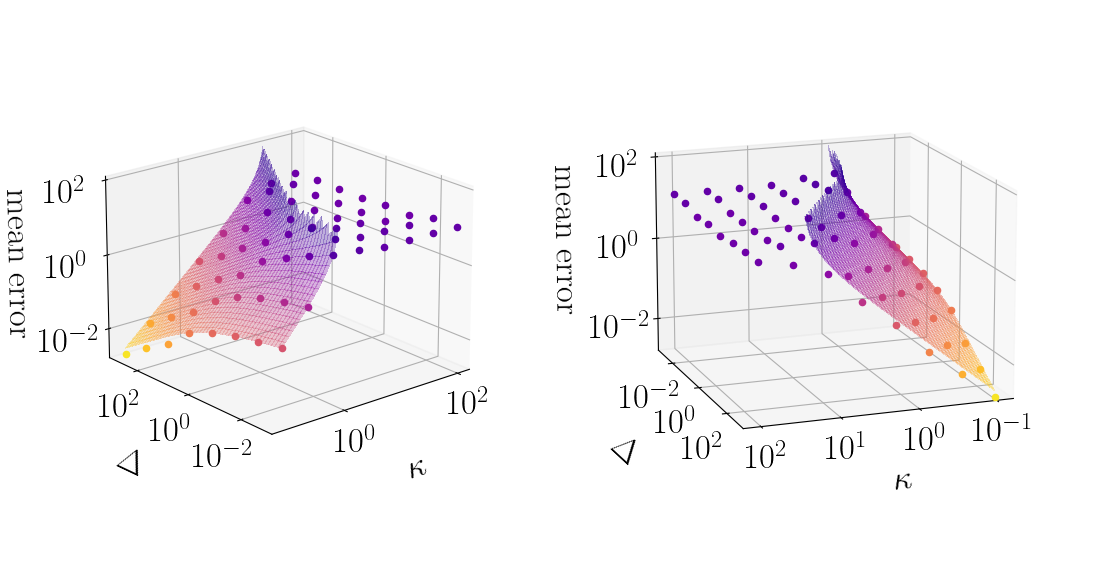

In [23]:
import matplotlib.ticker as mticker

# My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
    # return f"{10**val:.2e}"      # e-Notation

vmin = -3
vmax = 2
cmap= 'plasma_r'

fig = plt.figure(figsize=(14, 10))

ax_1 = fig.add_subplot(1, 2, 1, projection='3d')

for i in range(len(κ_tab)):
    for j in range(len(Δ_tab)):
        mean_err = np.mean(err_tab[i, j])
        ax_1.scatter(np.log10(κ_tab[i]), np.log10(Δ_tab[j]), np.log10(mean_err), 
                     c=np.log10(mean_err), cmap=cmap, vmin=vmin, vmax=vmax)
        
ax_1.set_xlabel(r'$\kappa$', labelpad=30)
ax_1.set_ylabel(r'$\Delta$', labelpad=35)
ax_1.set_zlabel('mean error', labelpad=30)

ax_1.tick_params(axis='z', which='major', pad=15)
ax_1.tick_params(axis='x', which='major', pad=5)
ax_1.tick_params(axis='y', which='major', pad=10)

ax_1.view_init(elev=20, azim=-130)
ax_1.set_zlim(-7.1, 6)
ax_1.set_ylim(-3, 3)
ax_1.set_zlim(-2.7, 2)

ax_1.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax_1.xaxis.set_major_locator(mticker.MaxNLocator(3, integer=True))
ax_1.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax_1.yaxis.set_major_locator(mticker.MaxNLocator(4, integer=True))
ax_1.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax_1.zaxis.set_major_locator(mticker.MaxNLocator(4, integer=True))

th_err_tab_plot = np.copy(th_err_tab)
th_err_tab_plot[th_err_tab_plot > 10**2] = np.nan

surf = ax_1.plot_surface(np.log10(X), np.log10(Y), np.log10(th_err_tab_plot), 
                         linewidth=0, antialiased=False, alpha=0.3, cmap=cmap, 
                         vmin=vmin, vmax=vmax)

ax_2 = fig.add_subplot(1, 2, 2, projection='3d')

for i in range(len(κ_tab)):
    for j in range(len(Δ_tab)):
        mean_err = np.mean(err_tab[i, j])
        ax_2.scatter(np.log10(κ_tab[i]), np.log10(Δ_tab[j]), np.log10(mean_err), 
                     c=np.log10(mean_err), cmap=cmap, vmin=vmin, vmax=vmax)
        
ax_2.set_xlabel(r'$\kappa$', labelpad=25)
ax_2.set_ylabel(r'$\Delta$', labelpad=35)
ax_2.set_zlabel('mean error', labelpad=35)

ax_2.view_init(elev=15, azim=-290)
ax_2.set_zlim(-7.1, 6)
ax_2.set_ylim(-3, 3)
ax_2.set_zlim(-2.7, 2)
ax_2.tick_params(axis='y', which='major', pad=10)
ax_2.tick_params(axis='z', which='major', pad=15)

ax_2.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax_2.xaxis.set_major_locator(mticker.MaxNLocator(4, integer=True))
ax_2.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax_2.yaxis.set_major_locator(mticker.MaxNLocator(4, integer=True))
ax_2.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax_2.zaxis.set_major_locator(mticker.MaxNLocator(4, integer=True))

surf = ax_2.plot_surface(np.log10(X), np.log10(Y), np.log10(th_err_tab_plot), 
                         linewidth=0, antialiased=False, alpha=0.1, cmap=cmap, 
                         vmin=vmin, vmax=vmax)

ax_1.set_box_aspect(aspect=None, zoom=0.74)
ax_2.set_box_aspect(aspect=None, zoom=0.8)

plt.subplots_adjust(wspace=0, hspace=-50)